# Bernoulli STM implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.ops.indexing import Vindex

import torch
from torch.distributions import constraints

import numpy as np
import pandas as pd

from zzz_utils_plot import *
from tm_bern import *

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(1234)

## Simulate

In [5]:
dist.LogisticNormal(torch.zeros(5), 2).sample([10])

tensor([[9.9598e-03, 5.8691e-01, 1.2333e-02, 2.8013e-02, 8.8237e-02, 2.7454e-01],
        [1.0304e-01, 2.8370e-03, 3.6638e-01, 4.0398e-01, 6.2370e-02, 6.1403e-02],
        [9.6463e-02, 2.1806e-02, 8.1980e-01, 3.7987e-03, 5.3462e-02, 4.6669e-03],
        [2.1599e-01, 6.7381e-01, 2.5658e-02, 1.9479e-03, 1.4444e-03, 8.1145e-02],
        [9.5278e-03, 3.4852e-01, 1.9404e-02, 4.1407e-01, 1.9467e-01, 1.3804e-02],
        [8.8334e-01, 5.7608e-02, 3.4643e-02, 8.4908e-03, 5.5621e-04, 1.5363e-02],
        [4.6599e-03, 5.1960e-01, 3.2341e-01, 1.1587e-01, 8.2352e-03, 2.8225e-02],
        [4.4424e-02, 3.5525e-01, 2.2296e-01, 8.8064e-02, 1.7375e-01, 1.1555e-01],
        [6.0916e-02, 1.1674e-01, 1.7435e-01, 5.9220e-02, 3.7393e-01, 2.1484e-01],
        [9.7098e-01, 2.4241e-04, 9.4109e-03, 1.0546e-02, 4.3690e-04, 8.3815e-03]])

In [54]:
P = 4
nTopics = 3
nCells = 20
X = dist.Normal(torch.zeros(P), 1).sample([nCells])
print(X.shape)
gamma = dist.Normal(0, 1).sample([P, nTopics-1])
print(gamma.shape)
print(gamma)

torch.Size([20, 4])
torch.Size([4, 2])
tensor([[ 0.6289, -0.0140],
        [ 2.0691,  0.7698],
        [-0.9317, -0.2062],
        [-0.3701,  1.2477]])


In [55]:
torch.matmul(X, gamma)

tensor([[-0.5972, -0.8554],
        [-4.1452, -0.2731],
        [ 0.6476,  1.7255],
        [-3.6621, -2.3526],
        [ 1.0524,  0.2472],
        [-2.0857, -1.2490],
        [-4.6198, -1.8569],
        [ 3.6907, -1.3046],
        [ 1.7320, -0.4011],
        [ 2.5123,  0.3755],
        [ 4.8809,  0.6108],
        [-1.0506, -1.1095],
        [ 0.7713,  1.2015],
        [-0.5403, -0.5861],
        [-1.3754, -2.7323],
        [ 3.6545,  2.3485],
        [ 2.9056,  1.4556],
        [ 2.8590,  0.2029],
        [ 0.7626, -0.9421],
        [-1.1503, -0.6934]])

In [57]:
theta = dist.LogisticNormal(torch.matmul(X, gamma), 0.1).sample()

tensor([[0.1946, 0.2488, 0.5566],
        [0.0080, 0.4570, 0.5349],
        [0.4684, 0.4582, 0.0734],
        [0.0117, 0.0852, 0.9031],
        [0.6049, 0.2189, 0.1762],
        [0.0557, 0.1961, 0.7482],
        [0.0051, 0.1244, 0.8705],
        [0.9579, 0.0089, 0.0333],
        [0.7533, 0.0980, 0.1487],
        [0.8647, 0.0805, 0.0548],
        [0.9852, 0.0099, 0.0049],
        [0.1628, 0.1837, 0.6534],
        [0.5094, 0.3811, 0.1095],
        [0.2172, 0.2696, 0.5131],
        [0.1016, 0.0478, 0.8506],
        [0.9562, 0.0397, 0.0041],
        [0.9115, 0.0726, 0.0159],
        [0.8991, 0.0587, 0.0422],
        [0.5333, 0.1519, 0.3149],
        [0.1327, 0.2220, 0.6453]])

In [2]:
##### Simulation strategy
nCells = 400
nRegions = 300
nTopics = 3
a = torch.ones(nTopics) / 2

# Detection rate (coverage)
cov = dist.Beta(2, 2).sample([nRegions])# + 0.02
# Cell topics distribution
theta = dist.Dirichlet(a).sample([nCells])
# Topics region distribution
phi = LogitNormal(0, 3).sample([nTopics, nRegions])

D_np = np.empty([nCells, nRegions], dtype = np.float32)
# Simulate each cell
for c in range(nCells):
    for r in range(nRegions):
        # Sample topics and corresponding regions
        z = dist.Categorical(theta[c, :]).sample()
        w = dist.Bernoulli(phi[z, r] * cov[r]).sample().detach().tolist()
        D_np[c, r] = w

# Transpose to have nRegions x nCells
D = torch.from_numpy(D_np).t()

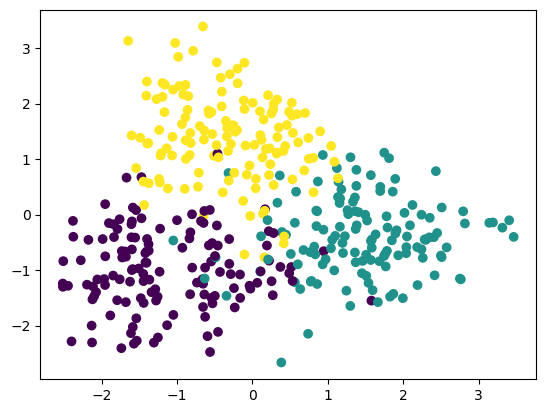

In [3]:
label = theta.detach().numpy()
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(D_np)
plot = plt.scatter(Xt[:,0], Xt[:,1], c = label.argmax(axis=1).tolist())
#plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.show()

In [4]:
#pyro.set_rng_seed(123)
#trace = pyro.poutine.trace(tm_bern_model).get_trace()
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

## Bernoulli topic model

Below we define the STM model with Pyro. Note that data D is a matrix of __nRegions x nCells__.

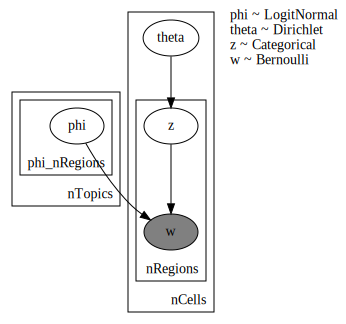

In [4]:
pyro.clear_param_store()
pyro.render_model(tm_bern_model, model_args=(D, nTopics), 
                  render_distributions=True, render_params=True)

## LDA guide (variational approximation)

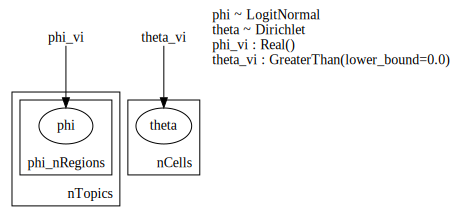

In [5]:
pyro.clear_param_store()
pyro.render_model(tm_bern_guide, model_args=(D, nTopics), 
                  render_distributions=True, render_params=True)

# Testing variational inference

In [6]:
# Filter to keep only regions with decent coverage
det_thr = 0.1

qc_peak_idx = np.where(np.array(D.mean(axis=1)) > det_thr)[0]
print('Number of peak regions passing QC threshold:', len(qc_peak_idx))
D_filt = D[qc_peak_idx, :]
print(D_filt.shape)

Number of peak regions passing QC threshold: 227
torch.Size([227, 400])


## Fit LDA 

To perform inference for TM Bernoulli with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [7]:
nTopics = 3
nSteps = 1000
lr = 0.1
seed = 123

pyro.set_rng_seed(seed)
pyro.clear_param_store()

# We'll fit using SVI.
logging.info("-" * 40)
logging.info("Fitting {} cells".format(D.shape[1]))

elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)
optim = pyro.optim.Adam({"lr": lr, 'weight_decay':0.01})
svi = pyro.infer.SVI(tm_bern_model, tm_bern_guide, optim, elbo)
losses = []

logging.info("Step\tLoss")
for step in range(nSteps):
    loss = svi.step(D=D_filt, nTopics=nTopics)
    if step % 100 == 0:
        logging.info("{: >5d}\t{}".format(step, loss))
    losses.append(loss)
logging.info("final loss = {}".format(loss))

    81934 ----------------------------------------
    81935 Fitting 400 cells
    81936 Step	Loss
    81997     0	64185.05078125
    83669   100	54626.0546875
    85479   200	54429.59765625
    87392   300	54492.52734375
    89115   400	54526.21484375
    90879   500	54475.578125
    92632   600	54448.4140625
    94447   700	54426.6171875
    96244   800	54454.765625
    98060   900	54473.65625
    99855 final loss = 54467.40234375


Here we plot the elbo loss during optimisation

Text(0, 0.5, 'ELBO loss')

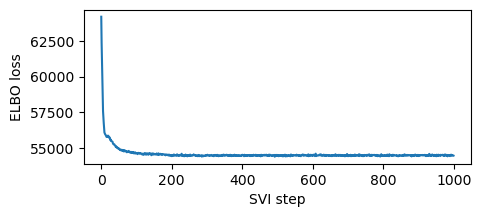

In [8]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [10]:
#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name).data.cpu().numpy())

In [9]:
pyro.param("theta_vi").detach()[1:10, :]

tensor([[11.6984,  0.2895,  0.4566],
        [ 0.3791,  0.4499, 15.3113],
        [ 2.8001,  0.2130,  6.3105],
        [ 0.4490,  0.2676,  5.6305],
        [ 2.3661,  0.2561,  4.9936],
        [ 4.0276,  0.2681,  0.8961],
        [ 5.4318,  0.1716,  3.1666],
        [17.5107,  0.2661,  0.6840],
        [ 0.4438,  0.3053, 11.3727]])

In [10]:
# A single sample from the guide
post_sample = tm_bern_guide(D = D_filt, nTopics = nTopics)

In [11]:
theta[1:10, ] # first 10 cells prob assignments to each topic

tensor([[0.1050, 0.7958, 0.0992],
        [0.7704, 0.1197, 0.1099],
        [0.6980, 0.2736, 0.0284],
        [0.7939, 0.1210, 0.0851],
        [0.1938, 0.4824, 0.3238],
        [0.4075, 0.5776, 0.0149],
        [0.1511, 0.6774, 0.1714],
        [0.1991, 0.7906, 0.0102],
        [0.0214, 0.1606, 0.8180]])

In [12]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[9.9694e-01, 2.8072e-03, 2.5169e-04],
        [1.6261e-02, 3.8083e-02, 9.4566e-01],
        [2.9689e-01, 8.2227e-02, 6.2088e-01],
        [7.0356e-04, 5.7428e-03, 9.9355e-01],
        [6.2935e-01, 8.7723e-04, 3.6977e-01],
        [6.0284e-01, 7.8084e-02, 3.1908e-01],
        [6.6095e-01, 7.7199e-09, 3.3905e-01],
        [9.9106e-01, 8.3148e-03, 6.2441e-04],
        [2.3332e-02, 6.6720e-02, 9.0995e-01]], grad_fn=<SliceBackward0>)

In [13]:
post_sample['phi'][1:10, :].detach().numpy() # posterior phi

array([[0.24604589, 0.43870243, 0.25735238],
       [0.4561087 , 0.41237202, 0.3911005 ],
       [0.18996547, 0.54339856, 0.20352475],
       [0.33592358, 0.45172903, 0.24480061],
       [0.31996894, 0.49093166, 0.3433347 ],
       [0.3530049 , 0.6128651 , 0.2663468 ],
       [0.23031081, 0.5965226 , 0.4030077 ],
       [0.28445682, 0.4584546 , 0.24034266],
       [0.22066903, 0.5292456 , 0.28351307]], dtype=float32)

In [14]:
phi[:, 1:10].transpose(0, 1)

tensor([[0.9667, 0.3381, 0.7918],
        [0.5103, 0.7149, 0.9979],
        [0.8021, 0.6009, 0.1116],
        [0.3325, 0.6247, 0.0650],
        [0.0688, 0.0104, 0.3187],
        [0.9766, 0.6840, 0.1757],
        [0.7559, 0.8751, 0.7343],
        [0.0122, 0.1376, 0.9793],
        [0.0101, 0.0010, 0.0098]])

### Topic-cell distribution plots

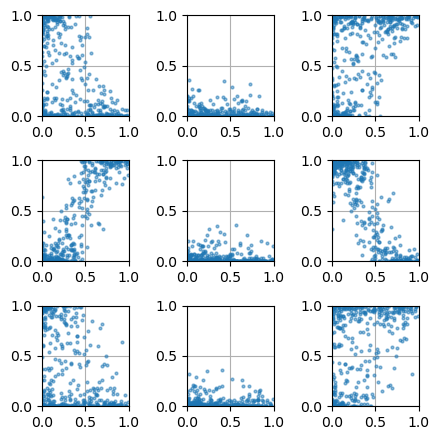

In [15]:
f = make_theta_comparison_plots(theta_true = theta, 
                                theta_infer = post_sample['theta'].detach().numpy())

### Topic-region distribution plots

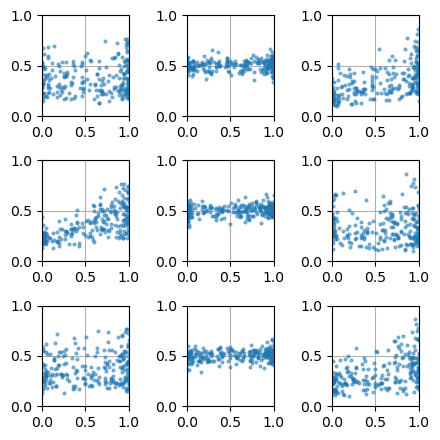

In [16]:
f = make_theta_comparison_plots(theta_true = phi[:, qc_peak_idx].transpose(0, 1), 
                                theta_infer = post_sample['phi'].detach().numpy())